In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
import cv2
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import tensorflow as tf 
import keras 
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [5]:
import os, random, numpy as np, tensorflow as tf
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [6]:
!pip install kagglehub -q
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmedismaiil/skin-issues-version-2-dataset-balanced")

print("Path to dataset files:", path)

files = os.listdir(path)
print("Files in the dataset directory:", files)

Path to dataset files: /kaggle/input/skin-issues-version-2-dataset-balanced
Files in the dataset directory: ['Skin v2']


In [7]:
Class_Names = os.listdir(os.path.join(path, 'Skin v2'))
Class_Names_dict = {name: idx for idx, name in enumerate(Class_Names)}
print("Class Mapping:", Class_Names_dict)

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
CHANNELS = 3

Class Mapping: {'acne': 0, 'dark spots': 1, 'wrinkles': 2, 'pores': 3, 'blackheades': 4}


In [8]:
def load_data(data_dir):
    Images = []
    Labels = []
    for folder in os.listdir(data_dir):
        print(f"Loading images from '{folder}' folder...")
        for img in tqdm(os.listdir(os.path.join(data_dir, folder))):
            img_path = os.path.join(data_dir, folder, img)
            image = cv2.imread(img_path)
            image = cv2.resize(image, IMAGE_SIZE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            Images.append(image)
            Labels.append(Class_Names_dict[folder])
    
    Images = np.array(Images, dtype='float32')
    Labels = np.array(Labels, dtype='int64')
    return Images, Labels

Images, Labels = load_data(os.path.join(path, 'Skin v2'))
Images, Labels = shuffle(Images, Labels, random_state=42)

print(f"\n✅ Total Images: {Images.shape[0]}")
print(f"✅ Image Size: {Images.shape[1:]}")

for i, cls in enumerate(Class_Names):
    print(f"Number of {cls} images: {len(Labels[Labels == i])}")

Loading images from 'acne' folder...


100%|██████████| 2060/2060 [00:16<00:00, 121.79it/s]


Loading images from 'dark spots' folder...


100%|██████████| 2126/2126 [00:23<00:00, 92.07it/s]


Loading images from 'wrinkles' folder...


100%|██████████| 1982/1982 [00:18<00:00, 109.15it/s]


Loading images from 'pores' folder...


100%|██████████| 1632/1632 [00:14<00:00, 111.96it/s]


Loading images from 'blackheades' folder...


100%|██████████| 1970/1970 [00:16<00:00, 119.26it/s]



✅ Total Images: 9770
✅ Image Size: (256, 256, 3)
Number of acne images: 2060
Number of dark spots images: 2126
Number of wrinkles images: 1982
Number of pores images: 1632
Number of blackheades images: 1970


In [10]:
Train_Images, dummy_Images, Train_Labels, dummy_Labels = train_test_split(
    Images, Labels, test_size=0.3, random_state=42, stratify=Labels
)
Val_Images, Test_Images, Val_Labels, Test_Labels = train_test_split(
    dummy_Images, dummy_Labels, test_size=0.5, random_state=42, stratify=dummy_Labels
)

_, train_counts = np.unique(Train_Labels, return_counts=True)
_, val_counts = np.unique(Val_Labels, return_counts=True)
_, test_counts = np.unique(Test_Labels, return_counts=True)

df = pd.DataFrame({'Train': train_counts, 'Validation': val_counts, 'Test': test_counts}, index=Class_Names)
print("\n Dataset Distribution:")
print(df)


 Dataset Distribution:
             Train  Validation  Test
acne          1442         309   309
dark spots    1488         319   319
wrinkles      1387         297   298
pores         1143         245   244
blackheades   1379         295   296


In [11]:
from tensorflow.keras.utils import to_categorical

# One-hot encoding
Train_Labels_cat = to_categorical(Train_Labels, num_classes=len(Class_Names))
Val_Labels_cat = to_categorical(Val_Labels, num_classes=len(Class_Names))
Test_Labels_cat = to_categorical(Test_Labels, num_classes=len(Class_Names))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Use .flow() for numpy arrays
train_generator = train_datagen.flow(Train_Images, Train_Labels_cat, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(Val_Images, Val_Labels_cat, batch_size=BATCH_SIZE, shuffle=False)
test_generator = test_datagen.flow(Test_Images, Test_Labels_cat, batch_size=BATCH_SIZE, shuffle=False)

**VGG16**

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(Class_Names), activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1761286253.738438      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761286253.739168      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,561,285 (120.40 MB)

 Trainable params: 16,845,317 (64.26 MB)

 Non-trainable params: 14,715,968 (56.14 MB)

In [14]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

In [15]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop, lr_reduce]
)


Epoch 1/100


I0000 00:00:1761286267.791327     107 service.cc:148] XLA service 0x7f37240065c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761286267.792399     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761286267.792421     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761286268.447345     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-10-24 06:11:15.827593: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6085 - loss: 1.1181
Epoch 1: val_loss improved from inf to 0.42528, saving model to best_model.h5
214/214 ━━━━━━━━━━━━━━━━━━━━ 144s 577ms/step - accuracy: 0.6089 - loss: 1.1170 - val_accuracy: 0.8560 - val_loss: 0.4253 - learning_rate: 1.0000e-04
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.7967 - loss: 0.5894
Epoch 2: val_loss did not improve from 0.42528
214/214 ━━━━━━━━━━━━━━━━━━━━ 98s 456ms/step - accuracy: 0.7967 - loss: 0.5893 - val_accuracy: 0.8096 - val_loss: 0.4801 - learning_rate: 1.0000e-04
Epoch 3/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8430 - loss: 0.4619
Epoch 3: val_loss improved from 0.42528 to 0.33135, saving model to best_model.h5
214/214 ━━━━━━━━━━━━━━━━━━━━ 98s 457ms/step - accuracy: 0.8430 - loss: 0.4620 - val_accuracy: 0.8771 - val_loss: 0.3314 - learning_rate: 1.0000e-04
Epoch 4/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8380 - loss: 0.4594
Epoc

In [16]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 516ms/step - accuracy: 0.9435 - loss: 0.1697

 Test Accuracy: 94.75%
 Test Loss: 0.1630


46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step

 Classification Report:
              precision    recall  f1-score   support

        acne       0.90      0.95      0.92       309
  dark spots       0.94      0.94      0.94       319
    wrinkles       0.97      0.97      0.97       298
       pores       0.97      0.98      0.98       244
 blackheades       0.96      0.90      0.93       296

    accuracy                           0.95      1466
   macro avg       0.95      0.95      0.95      1466
weighted avg       0.95      0.95      0.95      1466



<Figure size 800x600 with 0 Axes>

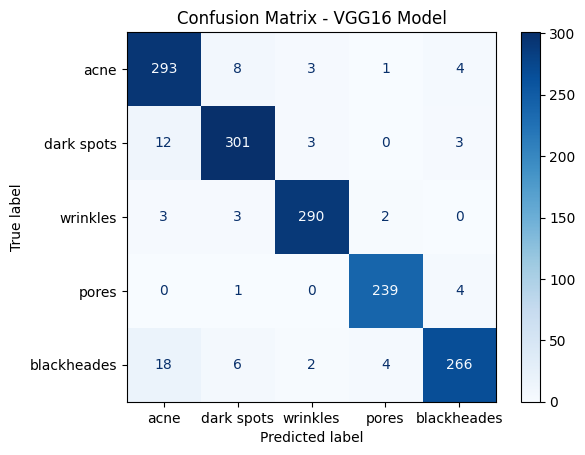

In [17]:
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Test_Labels_cat, axis=1)
class_labels = Class_Names

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - VGG16 Model")
plt.show()   

**Resnet_model**

In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


In [34]:

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                    input_shape=(256, 256, 3) ,
                   pooling='avg',classes=5,
                   weights='imagenet')

for layer in pretrained_model.layers:  
    layer.trainable = True

resnet_model = Sequential([
    pretrained_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])


resnet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 24,586,245 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [35]:
from tensorflow.keras.optimizers import Adam

resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),   
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 183s 553ms/step - accuracy: 0.6379 - loss: 1.1721 - val_accuracy: 0.2027 - val_loss: 4.3420
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 94s 435ms/step - accuracy: 0.8303 - loss: 0.5073 - val_accuracy: 0.2109 - val_loss: 2.8198
Epoch 3/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 101s 472ms/step - accuracy: 0.8740 - loss: 0.3896 - val_accuracy: 0.3031 - val_loss: 1.5683
Epoch 4/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 97s 451ms/step - accuracy: 0.8959 - loss: 0.3147 - val_accuracy: 0.2553 - val_loss: 4.7409
Epoch 5/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 97s 450ms/step - accuracy: 0.8980 - loss: 0.3091 - val_accuracy: 0.4614 - val_loss: 1.8031
Epoch 6/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 95s 440ms/step - accuracy: 0.9078 - loss: 0.2724 - val_accuracy: 0.7631 - val_loss: 1.2204
Epoch 7/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 97s 450ms/step - accuracy: 0.9201 - loss: 0.2450 - val_accuracy: 0.6478 - val_loss: 1.1180
Epoch 8/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 95s 443ms/step - accuracy: 0.9215

In [37]:
test_loss, test_acc = resnet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9398 - loss: 0.1887
Test Accuracy: 0.9400


46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step

 Classification Report:
              precision    recall  f1-score   support

        acne       0.94      0.93      0.93       309
  dark spots       0.94      0.93      0.94       319
    wrinkles       0.92      0.99      0.95       298
       pores       0.94      1.00      0.97       244
 blackheades       0.97      0.86      0.91       296

    accuracy                           0.94      1466
   macro avg       0.94      0.94      0.94      1466
weighted avg       0.94      0.94      0.94      1466



<Figure size 800x600 with 0 Axes>

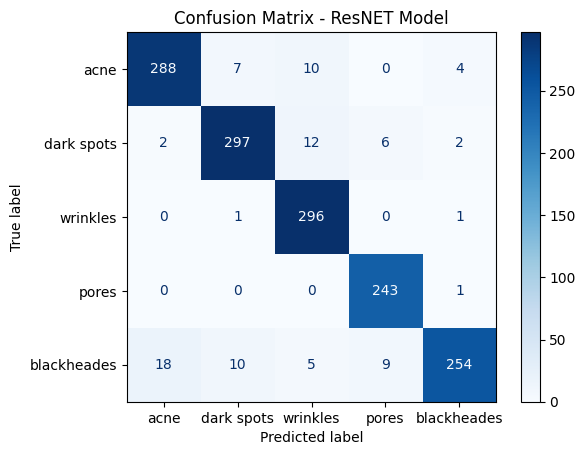

In [38]:
y_pred_probs = resnet_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Test_Labels_cat, axis=1)
class_labels = Class_Names

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - ResNET Model")
plt.show()   